In [1]:
%matplotlib inline

import imageio
import scipy.stats
import scipy.special

import numpy as np
import pandas as pd
from numpy import array as arr

import os
import re
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from astropy.io import fits

from scipy.stats import sem 
from scipy import ndimage as ndi
from scipy.optimize import curve_fit

import sys
sys.path.append('../../Analysis_code/klab_python_lib/')

import klib

### Can comment below if not editing klib
%load_ext autoreload
%aimport klib
%autoreload

In [2]:
from typing import Optional
import cv2
from pymba import Vimba, VimbaException, Frame
import time

# todo add more colours
PIXEL_FORMATS_CONVERSIONS = {
    'BayerRG8': cv2.COLOR_BAYER_RG2RGB,
}


def display_frame(frame: Frame, delay: Optional[int] = 1) -> None:
    """
    Displays the acquired frame.
    :param frame: The frame object to display.
    :param delay: Display delay in milliseconds, use 0 for indefinite.
    """
    print('frame {}'.format(frame.data.frameID))

    # get a copy of the frame data
    image = frame.buffer_data_numpy()

    plt.imshow(image)
    plt.show()
#     # convert colour space if desired
#     try:
#         image = cv2.cvtColor(image, PIXEL_FORMATS_CONVERSIONS[frame.pixel_format])
#     except KeyError:
#         pass

#     # display image
#     cv2.imshow('Image', image)
#     cv2.waitKey(delay)

def print_camera_options(cameraID):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()

        # get feature value via feature object
        for feature_name in camera.feature_names():
            feature = camera.feature(feature_name)

            try:
                value = feature.value
                range_ = feature.range

                # alternatively the feature value can be read as an object attribute
                # value = getattr(camera, feature_name)
                # or
                # value = camera.someFeatureName

            except VimbaException as e:
                value = e
                range_ = None

            print('\n\t'.join(
                str(x) for x in (
                    feature_name,
                    'value: {}'.format(value),
                    'range: {}'.format(range_))
                if x is not None))

        camera.close()
    
def print_ids():
    with Vimba() as vimba:
        print(vimba.camera_ids())
        
def capture_image(cameraID, exposure = 50):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()
        
#         camera.feature('TriggerSource').value = 'Software'
        camera.feature('TriggerSource').value = 'Line2'
        camera.feature('TriggerSelector').value = 'FrameStart'
        camera.feature('AcquisitionFrameRateMode').value = 'Off'
        camera.feature('ExposureMode').value = 'Timed'
        camera.feature('ExposureTime').value = exposure
#         camera.feature('TriggerMode').value = 'Off'
        camera.feature('TriggerMode').value = 'On'

        camera.arm('SingleFrame')
        # capture a single frame, more than once if desired
        for i in range(1):
            try:
                frame = camera.acquire_frame()
            except VimbaException as e:
                # rearm camera upon frame timeout
                if e.error_code == VimbaException.ERR_TIMEOUT:
                    print(e)
                    camera.disarm()
                    camera.arm('SingleFrame')
                else:
                    raise
        image = frame.buffer_data_numpy()
        camera.disarm()
        camera.close()
        np.savetxt('tmp_img.txt', image, fmt='%d')
#         plt.imshow(image)

In [3]:
from ctypes import *
import pythoncom

gmoogLib = cdll.LoadLibrary('C:/Users/KLab/Desktop/AY code space/tweezer_balance/gmoogLib/x64/Release/gmoogLib.dll')

class GM_python(object):
    def __init__(self):
        gmoogLib.gm_new.argtypes = []
        gmoogLib.gm_new.restype = c_void_p
        
        gmoogLib.gm_test.argtypes = [c_void_p]
        gmoogLib.gm_test.restype = c_int
        
        gmoogLib.gm_zeroAll.argtypes = [c_void_p]
        gmoogLib.gm_zeroAll.restype = c_void_p
        
        gmoogLib.gm_endMessage.argtypes = [c_void_p]
        gmoogLib.gm_endMessage.restype = c_void_p
        
        gmoogLib.gm_setDAC.argtypes = [c_void_p, c_int, c_int, POINTER(c_float), POINTER(c_float), POINTER(c_float)]
        gmoogLib.gm_setDAC.restype = c_void_p
        
        self.obj = gmoogLib.gm_new()
    
    def test(self):
        gmoogLib.gm_test(self.obj)
    def zeroAll(self):
        gmoogLib.gm_zeroAll(self.obj)
    def endMessage(self):
        gmoogLib.gm_endMessage(self.obj)
    def setDAC(self, dac, channels, freqs, amps, phases):
        gmoogLib.gm_setDAC(self.obj, dac, channels, freqs, amps, phases)

gmoog = GM_python()

In [4]:
%autoreload

def getROIs(cameraID = 1, exposure = 50, bigRoiSettings = [360, 200, 100], roiSettings = [4, 8, 50], bgoff = (165,165)):
    #     Capture and parse image
    capture_image(cameraID, exposure = exposure)
    img = np.loadtxt('tmp_img.txt', dtype=int);
    plt.imshow(img)
    
    bigRoi = klib.analysis.find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
    img = img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]]

    rois, bgrois = klib.analysis.find_rois(img, *roiSettings, bgoff)
    
    return bigRoi, rois

def getNewAmps(ampsetD0, ampsetD1, freqsetD0, freqsetD1, phaseset, bigRoi, rois, DACoffset = 0, cameraID = 1, method = 'cross', bgoff = (165,165), ampscale = .01, double = False, exposure = 50):
    
    n = len(freqsetD0)
    
    ampset100 = np.ones(n)*100
    
#     Capture and parse image
    capture_image(cameraID, exposure = exposure)
    img = np.loadtxt('tmp_img.txt', dtype=int);
    
#     bigRoi = klib.analysis.find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
    img = img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]]

#     rois, bgrois = klib.analysis.find_rois(img, *roiSettings, bgoff)

    roisums = np.array(list(map(lambda roi: klib.analysis.get_roi_sum(img, roi, bgoff, display=False, bgsub = True),rois)))

    # roi = rois[0]
    # iimg = img[roi[2]:roi[3],roi[0]:roi[1]]

    # fitdat, params, perr = klib.mathutil.gaussianBeamFit2D(iimg)
    # plt.imshow(iimg)
    # plt.contour(fitdat)
    # plt.show()

#     Plot ROIS for verification
    
#     plt.plot(roisums, 'ko')
#     # plt.axis([-.1, 11.1, 0, 1.1*max(roisums)])
#     plt.xlabel('spot number')
#     plt.ylabel('brightness')
#     plt.axhline(y=np.mean(roisums))
#     plt.show()
    print('Mean val:', np.mean(roisums))

    if DACoffset==0:
        sign = 1 # for dac 0, 1
    elif DACoffset==2:
        sign = -1 # for dac 2, 3
    else:
        raise ValueError('Invalid DAC offset.')
        
    err = (roisums.reshape((n,n))[::-sign,:]-roisums.mean())/roisums.mean()*100
    maxerr = np.max(np.abs(err))

    plt.imshow(err)
    plt.xlabel("DAC 0")
    plt.ylabel("DAC 1")
    cbar = plt.colorbar()
    cbar.set_label('Fractional offset (%)')
    plt.show()
    
    if method == 'cross':
        roisumsD0 = roisums.reshape((n,n))[n//2,::sign]  #DAC0
        roisumsD1 = roisums.reshape((n,n))[::-sign,n//2]  #DAC1    
        
    elif method == 'mean':
        roisumsD0 = np.mean(roisums.reshape((n,n))[:, ::sign], axis = 0)  #DAC0
        roisumsD1 = np.mean(roisums.reshape((n,n))[::-sign,:], axis = 1)  #DAC1
    
    elif method == 'randomCross':
        roisumsD0 = roisums.reshape((n,n))[np.random.randint(n),::sign]  #DAC0
        roisumsD1 = roisums.reshape((n,n))[::-sign,np.random.randint(n)]  #DAC1    

    else:
        raise ValueError('Invalid method selection: ' + method)
    
    ampoutD0 = ampsetD0 - (roisumsD0-np.mean(roisumsD0))*ampscale
    ampoutD1 = ampsetD1 - (roisumsD1-np.mean(roisumsD1))*ampscale
    
    ampMax = np.max([ampoutD0, ampoutD1])
    if ampMax > 100:
        ampoutD0 = ampoutD0 - (ampMax - 100)
        ampoutD1 = ampoutD1 - (ampMax - 100)
    
    #     Send new values to GMoog
        
    gmoog.zeroAll()
    
    if double:
        amp100 = np.ones(n)*100
        seq = c_float * (2 * n)
        freqsetDD0 = np.concatenate((freqsetD0,freqsetD0))
        freqsetDD1 = np.concatenate((freqsetD1,freqsetD1))

        ampsetDD0 = np.concatenate((amp100, ampsetD0))
        ampsetDD1 = np.concatenate((amp100, ampsetD1))

        phasesetD = np.concatenate((phaseset,phaseset))
        gmoog.setDAC(0+DACoffset, 2*n, seq(*freqsetDD0), seq(*ampsetDD0), seq(*phasesetD))
        gmoog.setDAC(1+DACoffset, 2*n, seq(*freqsetDD1), seq(*ampsetDD1), seq(*phasesetD))
    
    else:
        seq = c_float * n
        gmoog.setDAC(0+DACoffset, n, seq(*freqsetD0), seq(*ampsetD0), seq(*phaseset))
        gmoog.setDAC(1+DACoffset, n, seq(*freqsetD1), seq(*ampsetD1), seq(*phaseset))
        
    gmoog.endMessage()
    
    time.sleep(.2)
    
    return ampoutD0, ampoutD1, maxerr

Peaks found:1


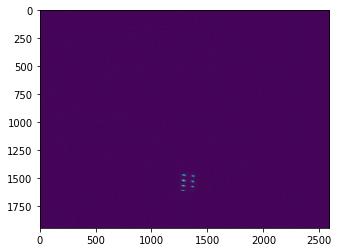

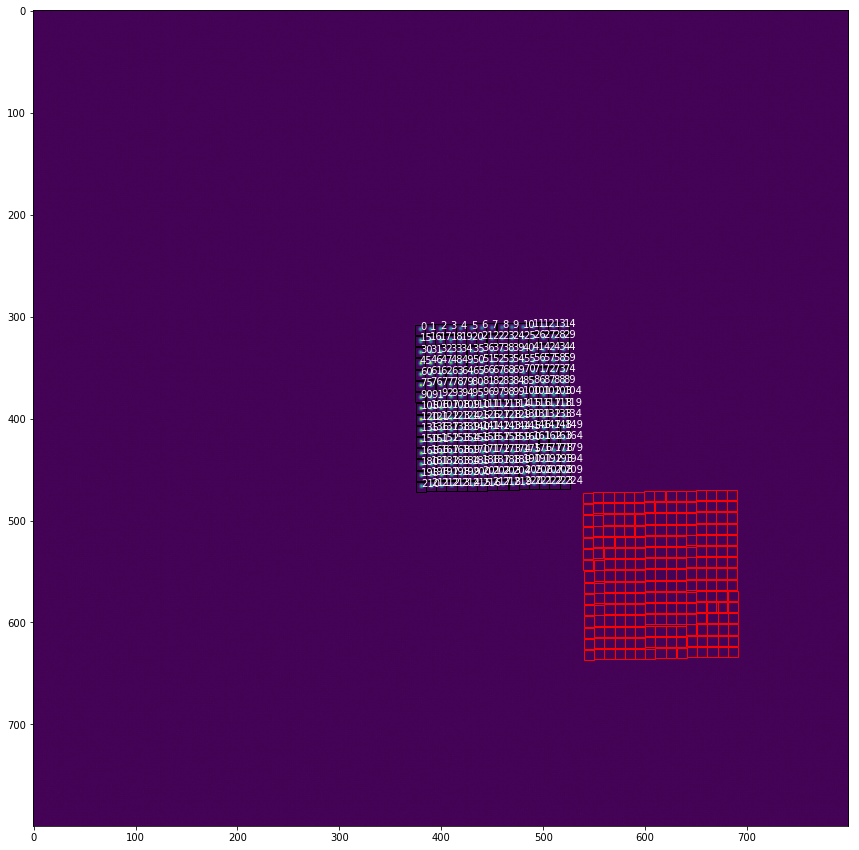

Peaks found:225
set DAC0 0 90.0 145.0 12.0
set DAC0 1 90.0 150.0 48.0
set DAC0 2 90.0 155.0 108.0
set DAC0 3 90.0 160.0 192.0
set DAC0 4 90.0 165.0 300.0
set DAC0 5 90.0 170.0 72.0
set DAC0 6 90.0 175.0 228.0
set DAC0 7 90.0 180.0 48.0
set DAC0 8 90.0 185.0 252.0
set DAC0 9 90.0 190.0 120.0
set DAC0 10 90.0 195.0 12.0
set DAC0 11 90.0 200.0 288.0
set DAC0 12 90.0 205.0 228.0
set DAC0 13 90.0 210.0 192.0
set DAC0 14 90.0 215.0 180.0

set DAC1 0 65.0 136.5 12.0
set DAC1 1 65.0 142.0 48.0
set DAC1 2 65.0 147.5 108.0
set DAC1 3 65.0 153.0 192.0
set DAC1 4 65.0 158.5 300.0
set DAC1 5 65.0 164.0 72.0
set DAC1 6 65.0 169.5 228.0
set DAC1 7 65.0 175.0 48.0
set DAC1 8 65.0 180.5 252.0
set DAC1 9 65.0 186.0 120.0
set DAC1 10 65.0 191.5 12.0
set DAC1 11 65.0 197.0 288.0
set DAC1 12 65.0 202.5 228.0
set DAC1 13 65.0 208.0 192.0
set DAC1 14 65.0 213.5 180.0


In [8]:
# Starting point for generating tones

numtones = 15

# DACoffset = 2 

# freqcenterD0 = 185+4*3-11 - 8.4
# spacingD0 = 4
# freqcenterD1 = 185+4.5*3-2*3.25 + 4.5 - 7
# spacingD1 = 4.5

# freqcenterD0 = 180.2888
# spacingD0 = 3.1888
# freqcenterD1 = 189.6888
# spacingD1 = 3.5077

# amp_guessD0 = 70
# amp_guessD1 = 70

DACoffset = 0

freqcenterD0 = 180
spacingD0 = 5
freqcenterD1 = 180-5
spacingD1 = 5.5

amp_guessD0 = 90
amp_guessD1 = 65

# offset = 1.3
double = False
cam = 2
exposure = 150

# if len(roisums) > numtones:
#     roisums = roisums[::2]

tone_inds = np.arange(numtones)

freqsD0 = np.arange(freqcenterD0-spacingD0*(numtones-1)/2, freqcenterD0+spacingD0*numtones/2, spacingD0)
freqsD1 = np.arange(freqcenterD1-spacingD1*(numtones-1)/2, freqcenterD1+spacingD1*numtones/2, spacingD1)

phases = np.pi*((tone_inds+1)**2)/(numtones)
phase_degs = np.round(phases*180/np.pi%360, 1)

ampscale = .001

init_ampsD0 = np.ones(numtones)*amp_guessD0
init_ampsD1 = np.ones(numtones)*amp_guessD1

ampD0 = init_ampsD0
ampD1 = init_ampsD1
err = 75

seq = c_float * numtones

gmoog.zeroAll()

if double:
    amp100 = np.ones(numtones)*100
    seq = c_float * (2 * numtones)
    freqsetDD0 = np.concatenate((freqsD0,freqsD0))
    freqsetDD1 = np.concatenate((freqsD1,freqsD1))

    ampsetDD0 = np.concatenate((amp100, ampD0))
    ampsetDD1 = np.concatenate((amp100, ampD1))

    phasesetD = np.concatenate((phase_degs,phase_degs))
    gmoog.setDAC(0+DACoffset, 2*numtones, seq(*freqsetDD0), seq(*ampsetDD0), seq(*phasesetD))
    gmoog.setDAC(1+DACoffset, 2*numtones, seq(*freqsetDD1), seq(*ampsetDD1), seq(*phasesetD))
else:
    gmoog.setDAC(0+DACoffset, len(freqsD0), seq(*freqsD0), seq(*ampD0), seq(*phase_degs))
    gmoog.setDAC(1+DACoffset, len(freqsD0), seq(*freqsD1), seq(*ampD1), seq(*phase_degs))

gmoog.endMessage()

time.sleep(.2)

bigRoi, rois = getROIs(cameraID = cam, exposure = exposure, roiSettings=[5,15,15], bigRoiSettings = [400, 200, 45])

if double:
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, amp100[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, amp100[ind], freqsD1[ind], phase_degs[ind])
    
    print()
    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds) + 1, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds) + 1, ampD1[ind], freqsD1[ind], phase_degs[ind])

else:    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs[ind])

In [12]:
while err > 8:
#     bigRoi, rois = getROIs(cameraID = cam, roiSettings=[5,10,15], bigRoiSettings = [300, 200, 100])
    ampD0, ampD1, err = getNewAmps(ampD0, ampD1, freqsD0, freqsD1, phase_degs, bigRoi, rois, cameraID = cam, method='mean', ampscale = 0.01, DACoffset = DACoffset, exposure = exposure, double = double)

print('Switch mode')
    
while err > 3.5:
#     bigRoi, rois = getROIs(cameraID = cam, roiSettings=[5,10,15], bigRoiSettings = [300, 200, 100])
    ampD0, ampD1, err = getNewAmps(ampD0, ampD1, freqsD0, freqsD1, phase_degs, bigRoi, rois, cameraID = cam, method='randomCross', ampscale = 0.005, DACoffset = DACoffset, exposure = exposure, double = double)

print('End')

Switch mode
End


In [14]:
# freqsD0 = freqsD0 + spacingD0/5
# freqsD1 = freqsD1 + spacingD1/5

if double:
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, amp100[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, amp100[ind], freqsD1[ind], phase_degs[ind])
    
    print()
    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds) + 1, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds) + 1, ampD1[ind], freqsD1[ind], phase_degs[ind])

else:    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs[ind])

set DAC0 0 80.9102 145.0 12.0
set DAC0 1 81.3392 150.0 48.0
set DAC0 2 80.5052 155.0 108.0
set DAC0 3 85.1088666667 160.0 192.0
set DAC0 4 91.8725333333 165.0 300.0
set DAC0 5 92.4875333333 170.0 72.0
set DAC0 6 89.3992 175.0 228.0
set DAC0 7 97.7552 180.0 48.0
set DAC0 8 95.1422 185.0 252.0
set DAC0 9 91.9428666667 190.0 120.0
set DAC0 10 94.1128666667 195.0 12.0
set DAC0 11 92.8122 200.0 288.0
set DAC0 12 89.4428666667 205.0 228.0
set DAC0 13 93.8938666667 210.0 192.0
set DAC0 14 93.2752 215.0 180.0

set DAC1 0 73.0922 136.5 12.0
set DAC1 1 63.9965333333 142.0 48.0
set DAC1 2 64.1278666667 147.5 108.0
set DAC1 3 60.7605333333 153.0 192.0
set DAC1 4 59.9688666667 158.5 300.0
set DAC1 5 60.9118666667 164.0 72.0
set DAC1 6 56.4245333333 169.5 228.0
set DAC1 7 60.2892 175.0 48.0
set DAC1 8 63.5532 180.5 252.0
set DAC1 9 62.5475333333 186.0 120.0
set DAC1 10 64.6698666667 191.5 12.0
set DAC1 11 63.1025333333 197.0 288.0
set DAC1 12 69.7895333333 202.5 228.0
set DAC1 13 72.1138666667 208.0

In [14]:
for ind in tone_inds:
    print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], str(freqsD0[ind]) + '+xoff', phase_degs[ind])

print()

for ind in tone_inds:
    print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], str(freqsD1[ind]) + '+yoff', phase_degs[ind])

set DAC0 0 86.0325777778 145.0+xoff 12.0
set DAC0 1 85.0849111111 150.0+xoff 48.0
set DAC0 2 83.7542444444 155.0+xoff 108.0
set DAC0 3 89.5222444444 160.0+xoff 192.0
set DAC0 4 94.9522444444 165.0+xoff 300.0
set DAC0 5 95.3405777778 170.0+xoff 72.0
set DAC0 6 90.0285777778 175.0+xoff 228.0
set DAC0 7 98.4069111111 180.0+xoff 48.0
set DAC0 8 93.6455777778 185.0+xoff 252.0
set DAC0 9 90.0439111111 190.0+xoff 120.0
set DAC0 10 90.8392444444 195.0+xoff 12.0
set DAC0 11 89.4239111111 200.0+xoff 288.0
set DAC0 12 84.9029111111 205.0+xoff 228.0
set DAC0 13 89.7899111111 210.0+xoff 192.0
set DAC0 14 88.2322444444 215.0+xoff 180.0

set DAC1 0 66.4389111111 136.5+yoff 12.0
set DAC1 1 60.1645777778 142.0+yoff 48.0
set DAC1 2 62.3009111111 147.5+yoff 108.0
set DAC1 3 61.0092444444 153.0+yoff 192.0
set DAC1 4 61.1639111111 158.5+yoff 300.0
set DAC1 5 63.5845777778 164.0+yoff 72.0
set DAC1 6 60.3719111111 169.5+yoff 228.0
set DAC1 7 64.8542444444 175.0+yoff 48.0
set DAC1 8 67.3132444444 180.5+yoff 2

NameError: name 'bg_offset' is not defined

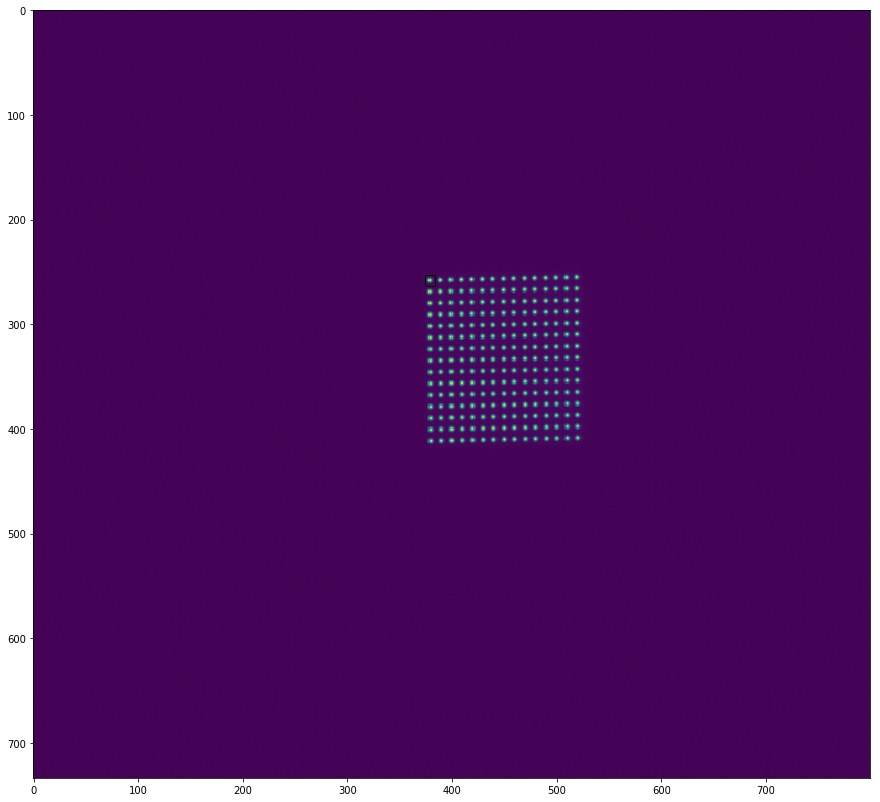

In [15]:
capture_image(cameraID = cam, exposure = exposure)
img = np.loadtxt('tmp_img.txt', dtype=int);

bgoff = (0,-160)

fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]])
for i in range(len(rois)):
    roi = rois[i]
    ax.add_patch(
    patches.Rectangle((roi[0], roi[2]), roi[1]-roi[0], roi[3]-roi[2], fill = False, color = 'black'))
    ax.add_patch(
    patches.Rectangle((roi[0]+bg_offset[0], roi[2]+bg_offset[1]), roi[1]-roi[0], roi[3]-roi[2], fill = False, color = 'red'))

#     plt.text(xys[i,1],xys[i,0],str(i), color = 'white')


roisums = np.array(list(map(lambda roi: klib.analysis.get_roi_sum(img, roi, bgoff, display=False, bgsub = True),rois)))

print('Mean val:', np.mean(roisums))
plt.imshow((roisums.reshape((numtones,numtones))[::-1,:]-roisums.mean())/roisums.mean()*100)
plt.xlabel("DAC 0")
plt.ylabel("DAC 1")
cbar = plt.colorbar()
cbar.set_label('Fractional offset (%)')
plt.show()

Peaks found:1


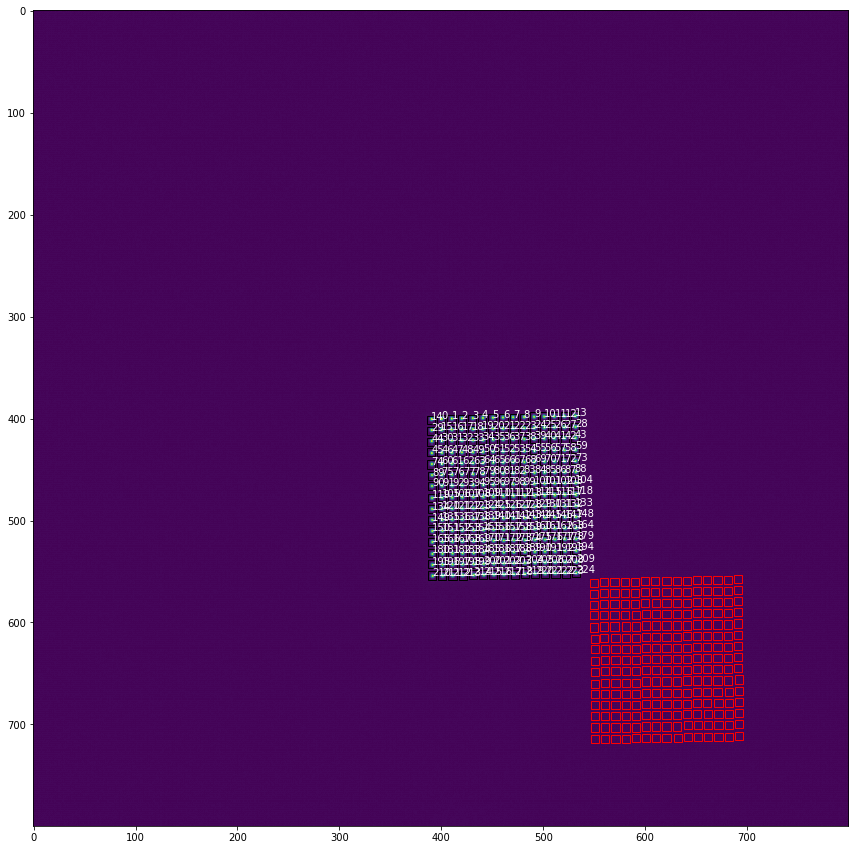

Peaks found:225
Mean val: 1857.25333333


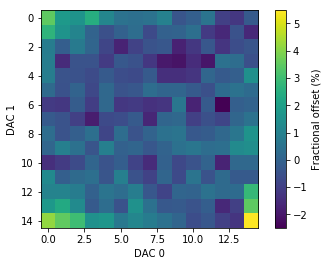

In [13]:
# %autoreload
capture_image(cameraID = cam, exposure = exposure)
img = np.loadtxt('tmp_img.txt', dtype=int);

bigRoiSettings = [400, 200, 50]
roiSettings=[4,16,25]
bgoff = (160,160)
bigRoi = klib.analysis.find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
img = img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]]

rois, bgrois = klib.analysis.find_rois(img, *roiSettings, bgoff)

roisums = np.array(list(map(lambda roi: klib.analysis.get_roi_sum(img, roi, bgoff, display=False, bgsub = True),rois)))

# roi = rois[0]
# iimg = img[roi[2]:roi[3],roi[0]:roi[1]]

# fitdat, params, perr = klib.mathutil.gaussianBeamFit2D(iimg)
# plt.imshow(iimg)
# plt.contour(fitdat)
# plt.show()

# plt.plot(roisums, 'ko')
# # plt.axis([-.1, 11.1, 0, 1.1*max(roisums)])
# plt.xlabel('spot number')
# plt.ylabel('brightness')
# plt.axhline(y=np.mean(roisums))
# plt.show()

print('Mean val:', np.mean(roisums))
plt.imshow((roisums.reshape((numtones,numtones))[::-1,:]-roisums.mean())/roisums.mean()*100)
plt.xlabel("DAC 0")
plt.ylabel("DAC 1")
cbar = plt.colorbar()
cbar.set_label('Fractional offset (%)')
plt.show()